# Vehicle Route Planning

## Packages

In [ ]:
#!pip install folium osmnx networkx ortools snowflake-connector-python openrouteservice -q

In [1]:
## Data Acess and Manipulation
import json
import numpy as np
import pandas as pd
import snowflake.connector as sf

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## for vehicle route planning
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

## Utilities
import os
import logging
from functools import partial
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor as Executor

## Geospatial Work
import folium
from folium import plugins
import osmnx as ox
import networkx as nx
from shapely.geometry import shape, Point
from math import sin, cos, sqrt, atan2, radians

## Multiprocessing
from multiprocessing import Pool, cpu_count

In [2]:
# Notebook Configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Data


### Item Weights Master

In [3]:
# Weights Master
df_weights = pd.read_excel(
    r'assets\data\Item Weight.xlsx'
    )

print(f"Shape of the imported dataset is: {df_weights.shape}")
df_weights.head(5)

Shape of the imported dataset is: (677, 2)


,itemCode,itemWeight
0,GOSF0001,10.6
1,DBRF0006,0.1
2,AEHG0009,1.0
3,GRND0001,0.4
4,ULPL0014,1.0


### Order (Line Level)

In [4]:
data_query = '''
        WITH
        entries as
        (   select
                regexp_replace("SOURCE NO_", '[A-Z]') AS "customerCode",
                "ITEM LEDGER ENTRY NO_" as "itemLedgerEntryNo",
                "EXTERNAL DOCUMENT NO_" AS "externalDocumentNo",
                "ITEM NO_" AS "itemCode",
                "DESCRIPTION" as "itemDescription",
                "LOCATION CODE" as "locationCode",
                "O ITEM LEDGER ENTRY QUANTITY"*-1 as "invoiceQuantity",
                "O SALES AMOUNT" as "saleValue",
                "O COST AMOUNT" as "costValue",
                MIN("O DOCUMENT DATE") OVER (PARTITION BY "EXTERNAL DOCUMENT NO_") as "invoiceDate"
            from buygro.ads.adj_vle
            where "O DOCUMENT DATE" = '2024-02-06'
        ),
        customer_details as
        (
            select distinct
                "ecvId",
                "erpId",
                "source",
                "name",
                replace(parse_json("details"):city, '"', '') as "city",
                replace(parse_json("details"):region, '"', '') as "region",
                replace(parse_json("details"):address, '"', '') as "address",
                parse_json("details"):location:lat as "lattitude",
                parse_json("details"):location:long as "longitude"
            from buygro.raw_ecv.bg_ecv_users
        ),
        item_details as
        (
            select
                item_code,
                description,
                min(physical_wt/physical_qty) as item_weight
            from BUYGRO.RAW.AFSYS_V_STK_DETAIL_WITH_DMG_DETAILS
            where customer = 'BUYGRO'
            and bin <> 'DESBIN'
            group by 1, 2
        )
        select
            b."name" as "customerName",
            b."source" as "customerSource",
            b."city" as "customerCity",
            b."region" as "customerRegion",
            b."address" as "customerAddress",
            b."lattitude" as "customerLat",
            b."longitude" as "customerLong",
            c.item_weight as "itemWeight",
            c.item_weight*"invoiceQuantity" as "itemTotalWeight",
            a.*
        from entries as a
        left join customer_details as b on a."customerCode" = b."ecvId"
        left join item_details as c on a."itemCode" = c.item_code

'''

In [5]:
conn = sf.connect(
    user=os.getenv("sf_user"),
    password=os.getenv("sf_pwd") ,
    account=os.getenv("sf_account") ,
    database='BUYGRO',
    warehouse='BUYGRO_ANALYSIS',
    schema='RAW_ECV'
)

cur = conn.cursor()
cur.execute(data_query)
df = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
cur.close()
conn.close()

print(f"Shape of the imported dataset is: {df.shape}")

Shape of the imported dataset is: (3775, 19)


### ADS

In [6]:
# Copy
df_copy = df.copy()

# Merge weights master with orders
df = df.merge(df_weights, on='itemCode', how='left')
df['itemWeight'] = np.where(df.itemWeight_y.isna(), df.itemWeight_x, df.itemWeight_y)
df.drop(['itemWeight_x', 'itemWeight_y','itemTotalWeight'], axis=1, inplace=True)
df['invoiceQuantity'] = df['invoiceQuantity'].astype(float)
df['saleValue'] = df['saleValue'].astype(float)
df['costValue'] = df['costValue'].astype(float)
df['itemTotalWeight'] = df['itemWeight']*df['invoiceQuantity']
df.head(5)

,customerName,customerSource,customerCity,customerRegion,customerAddress,customerLat,customerLong,customerCode,itemLedgerEntryNo,externalDocumentNo,itemCode,itemDescription,locationCode,invoiceQuantity,saleValue,costValue,invoiceDate,itemWeight,itemTotalWeight
0,AL GHABAT CITY SUPERMARKET,mobile,Abu Dhabi,Abu Dhabi,8G9P+QR7 - Mohamed Bin Zayed City - Shabiya 12...,24.319534,54.5371985,6308,1727890,20323083,LEAT0012,"Dettol Floor Cleaner- Pine, 2 x 900 ml",NIP,5.0,70.00,-58.98,2024-02-06,2.0,10.0
1,SHOROOQ AL WARQA GROCERY LLC,mobile,Jebel Ali,Dubai,Al Warqa 3,25.1833999156951,55.421461192891,2954,1728416,20323203,MMDR257,"Parliament Cigarette - Aqua Blue, 10 Packs",NIP,1.0,137.26,-136.26,2024-02-06,1.4,1.4
2,SEALAND SUPERMARKET,mobile,Sharjah,Sharjah,Rolla Near Al Butain Supermarket Behind Rak Ba...,25.1118751,55.2059213,4570,1729297,20323339,DBRF0029,"Mountain Dew, 1.5 Litre",NIP,6.0,25.50,-24.78,2024-02-06,1.5,9.0
3,HAPPY LAND GROCERY,mobile,Abu Dhabi,Abu Dhabi,Defence Road Al Nahyan Compound Near National ...,24.47581297,54.38082385,9793,1727160,20322966,DBRF0008,"Mountain Dew - Glass Bottle, 250 ml",NIP,0.0,0.00,0.01,2024-02-06,0.5,0.0
4,HAPPY LAND GROCERY,mobile,Abu Dhabi,Abu Dhabi,Defence Road Al Nahyan Compound Near National ...,24.47581297,54.38082385,9793,1727160,20322966,DBRF0008,"Mountain Dew - Glass Bottle, 250 ml",NIP,24.0,60.72,-59.15,2024-02-06,0.5,12.0


In [8]:
# load GeoJSON file containing sectors
with open(r'assets\data\GeoPloygon Data\GeoJSON\boundary-polygon-lvl2.geojson') as f:
    js = json.load(f)

def point_in_poly(js, latitude, longitude):
    try:
        point = Point(longitude, latitude)
    except TypeError:
        return (latitude, longitude)
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return True

df['customLocValidFlg'] = df.apply(lambda x: point_in_poly(js, x['customerLat'], x['customerLong']), axis=1)

In [ ]:
# Placeholder to enrcich the data using geojson information

In [9]:
print(f"Shape of data queried: {df.shape}")

print(f"Total number of rows associated to returns: {df[df['invoiceQuantity'] < 0].shape} will be dropped\n")
df.drop(df[df['invoiceQuantity'] < 0].index, inplace=True)

print(f"Total Number of rows with null weight: {df['itemWeight'].isna().sum(axis=0)} will be dropped\n")
df[df['itemWeight'].isna()]
df.dropna(subset=['itemWeight'], inplace=True)

print(f"Total Number of rows with null customer location: {df[(df['customerLong'] == '0') & (df['customerLat'] == '0')].shape} will be dropped\n")
df.drop(df[(df['customerLong'] == '0') & (df['customerLat'] == '0')].index, inplace=True)

print(f"Total Number of rows with incorrect location {df[df['customLocValidFlg'] != True].shape} will be dropped\n")
df.drop(df[df['customLocValidFlg'] != True].index, inplace=True)

print(f"Shape of data after preprocessing: {df.shape}")

Shape of data queried: (3775, 20)
Total number of rows associated to returns: (201, 20) will be dropped

Total Number of rows with null weight: 47 will be dropped

Total Number of rows with null customer location: (10, 20) will be dropped

Total Number of rows with incorrect location (0, 20) will be dropped

Shape of data after preprocessing: (3517, 20)


## Exploration

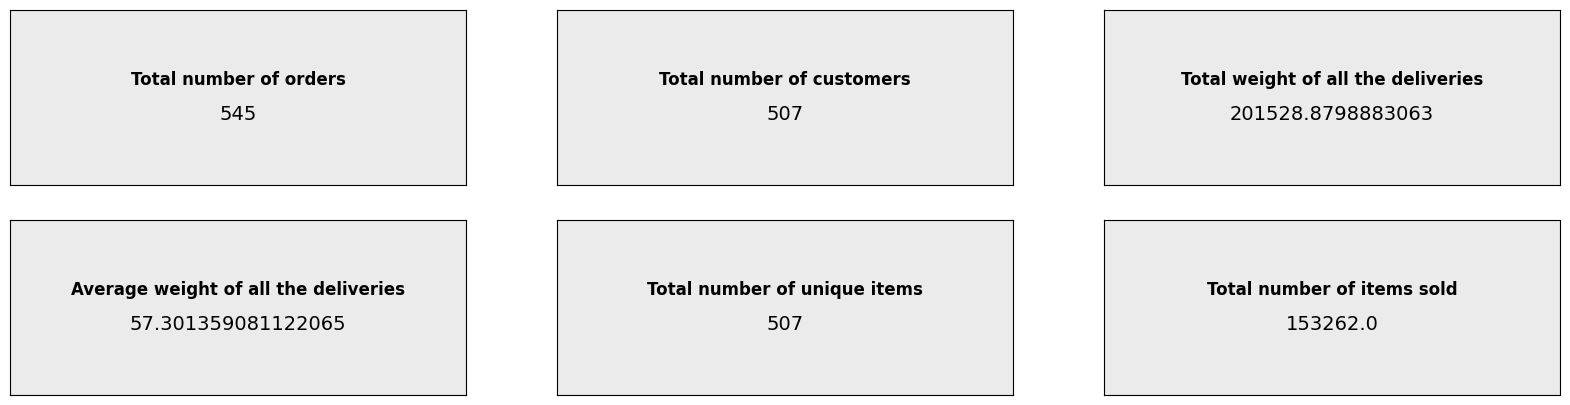

In [10]:
# Placeholder cells for some exploratory statistics
def key_iterator(item):
    """
    Creates an iterator over the dictionary keys.
    """
    return iter(item)

def get_next_key(key_iter):
    """
    Returns the next key from the key iterator.
    If all keys have been iterated, it restarts from the beginning or raises StopIteration.
    """
    try:
        return next(key_iter)
    except StopIteration:
        # Uncomment the following line if you want to restart the iteration once all keys are iterated
        # key_iter = iter(dictionary.keys())
        raise StopIteration("No more keys to iterate.")

def create_kpi_box(ax, title, value, color):
    # Use the entire axes to draw the rectangle
    ax.add_patch(Rectangle((0, 0), 1, 1, color=color, alpha=0.3, transform=ax.transAxes))

    # Add text
    ax.text(0.5, 0.6, title, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
    ax.text(0.5, 0.4, value, ha='center', va='center', fontsize=14, transform=ax.transAxes)

    # Remove the x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,5))


df_metrics = {
    "Total number of orders": df['externalDocumentNo'].nunique(),
    "Total number of customers": df['customerCode'].nunique(),
    "Total weight of all the deliveries": df['itemTotalWeight'].sum(),
    "Average weight of all the deliveries": df['itemTotalWeight'].mean(),
    "Total number of unique items": df['itemCode'].nunique(),
    "Total number of items sold": df['invoiceQuantity'].sum()
    }

key_iter = key_iterator(df_metrics.keys())

for row in range(2):
    for col in range(3):
        try:
            key = get_next_key(key_iter)
            create_kpi_box(ax[row,col], key, f"{df_metrics[key]}", 'silver')
        except StopIteration:
            break

In [11]:
# Gallega Cold Store
start = [24.931690466392208, 55.06185223067843]

# rolling up to Customer Level
order_details = df.groupby(['customerCode', 'customerName', 'customerAddress', 'customerRegion', 'customerLat', 'customerLong']).agg(
    {
        'externalDocumentNo': lambda x: pd.Series.nunique(x),
        'itemTotalWeight': 'sum',
        'itemCode': lambda x: pd.Series.nunique(x),
        'invoiceQuantity': 'sum',
        'saleValue': 'sum',
        'costValue': 'sum'
        }
    ).reset_index().copy()
order_details.rename(
    columns={
        'externalDocumentNo': 'totalOrders',
        'itemTotalWeight': 'totalWeight',
        'itemCode': 'totalItems'
        },
    inplace=True
    )
order_details['invoiceQuantity'] = order_details['invoiceQuantity'].abs()
order_details['costValue'] = order_details['costValue'].abs()
order_details['grossProfit'] = order_details['saleValue'] - order_details['costValue']
order_details['grossProfitMargin'] = order_details['grossProfit'] / order_details['saleValue'] * 100
order_details['customerRegion'] = order_details['customerRegion'].str.upper()

# Adding base row
base_row = {'customerCode': 0000,'customerName': 'base', 'customerAddress': 'base', 'customerRegion': 'base', 'customerLat': start[0], 'customerLong': start[1]}
order_details = pd.concat([pd.DataFrame(base_row, index=[0]), order_details], ignore_index=True)
order_details["base"] = order_details["customerName"].apply(lambda x: 1 if x=='base' else 0)

## Distance Matrix

In [18]:
class DistanceCalculator:
    def __init__(self, bbox=None, network_type="drive"):
        self.G = None
        self.bbox = bbox
        self.network_type = network_type

    def create_graph(self):
        if self.bbox is None:
            raise ValueError("Bounding box is not set.")
        north, south, east, west = self.bbox
        self.G = ox.graph_from_bbox(north, south, east, west, network_type=self.network_type)
        self.G = ox.add_edge_speeds(self.G)
        self.G = ox.add_edge_travel_times(self.G)
        logger.info("Graph created")

    def calculate_duration(self, a, b, units='travel_time', duration=True):
        if self.G is None:
            self.create_graph()
        if a == b:
            return 0
        try:
            route = nx.shortest_path(self.G, source=a, target=b, method='dijkstra', weight=units)
            attrs = ox.utils_graph.route_to_gdf(self.G, route)
        except nx.NetworkXNoPath:
            return np.nan
        except Exception as e:
            logger.error(f"Error {e} occurred for inputs {a}, {b}")
            return np.nan

        return attrs[units].sum() if duration else attrs['length'].sum()

    @staticmethod
    def haversine_dist( x, y):
        # Approximate radius of earth in km
        R = 6373.0

        lat1 = radians(float(x[0]))
        lon1 = radians(float(x[-1]))
        lat2 = radians(float(y[0]))
        lon2 = radians(float(y[-1]))

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c

        return distance

    @staticmethod
    def calculate_gd(args):
        x, y = args
        return DistanceCalculator.haversine_dist(x, y)

    def pairwise_distance(self, args, method='GD'):
        p1, p2 = args
        if method == 'GD':
            return self.calculate_gd((p1, p2))
        elif method == 'GRAPH':
            return self.calculate_duration(p1, p2)

    def df_to_dm(self, df, lat_col, long_col, uid, demand_ref, base_flag, method='GD'):
        if not isinstance(df, pd.DataFrame):
            raise ValueError("df must be a pandas DataFrame")

        required_cols = [lat_col, long_col, uid, demand_ref, base_flag]
        if not all(col in df.columns for col in required_cols):
            raise ValueError(f"DataFrame must contain columns: {required_cols}")

        xy_coordinates = list(map(lambda x: list(x), df[[lat_col, long_col]].values))
        xy_ids = df[uid].to_list()
        xy_demand = list(df[demand_ref].values.flatten())
        xy_demand[0] = 0

        max_workers = cpu_count()
        chunksize = 10  # Experiment with this value

        if method == 'GD':
            all_pairs = [(p1, p2) for p1 in xy_coordinates for p2 in xy_coordinates]
        elif method == 'GRAPH':
            if self.G is None:
                self.create_graph()
            xy_coordinates = list(map(lambda x: ox.distance.nearest_nodes(self.G, x[1], x[0]), xy_coordinates))
            all_pairs = [(p1, p2) for p1 in xy_coordinates for p2 in xy_coordinates]

          #with Executor(max_workers=max_workers) as executor:
        dm = list(map(partial(self.pairwise_distance, method=method), all_pairs))
        dm_matrix = np.array(dm).reshape(len(xy_coordinates), len(xy_coordinates))

        # Normalizing data for optumizer
        dm_matrix = dm_matrix*100
        dm_matrix = dm_matrix.astype(int)
        xy_demand = list(map(int, xy_demand))

        logger.info(f"Average distance between the points: {dm_matrix.mean()}")
        logger.info(f"Range distance between the points: {dm_matrix.min()} - {dm_matrix.max()}")

        return xy_ids, xy_coordinates, xy_demand, dm_matrix

In [19]:
# Usage
bbox = (22.4969475367, 26.055464179, 51.5795186705, 56.3968473651)  # Set only if using 'GRAPH' method
distance_calculator = DistanceCalculator(bbox=bbox, network_type="drive")
id, coordinates, demand, dm = distance_calculator.df_to_dm(order_details, 'customerLat', 'customerLong', 'customerCode', 'totalWeight', 'base', 'GD')

In [48]:
dm

array([[    0,  8606,  8702, ...,  6325,  8790,  6409],
       [ 8606,     0,   289, ..., 14777,   340, 14883],
       [ 8702,   289,     0, ..., 14836,    89, 14945],
       ...,
       [ 6325, 14777, 14836, ...,     0, 14922,   165],
       [ 8790,   340,    89, ..., 14922,     0, 15031],
       [ 6409, 14883, 14945, ...,   165, 15031,     0]])

## Constraint Optimization

In [38]:
def get_num_trucks(total_weight):
    # Calculate the ideal weights based on a 70-30 mix
    weight_3ton = 0.7 * total_weight
    weight_1ton = 0.3 * total_weight

    # Calculate the number of trucks, rounding to the nearest whole number
    num_3ton_trucks = round(weight_3ton / 3000)
    num_1ton_trucks = round(weight_1ton / 1000)

    # Calculate the total weight these trucks can carry
    total_carried_weight = (num_3ton_trucks * 3000) + (num_1ton_trucks * 1000)

    # Adjusting for the remainder if total carried weight is less than total weight
    while total_carried_weight < total_weight:
        # Check which addition gets closer to the goal
        if (total_weight - total_carried_weight) >= 3000:
            num_3ton_trucks += 1
            total_carried_weight += 3000
        else:
            num_1ton_trucks += 1
            total_carried_weight += 1000

    return [3000] * num_3ton_trucks + [1000] * num_1ton_trucks + [1000]*100

truck_weights = get_num_trucks(sum(demand))
len(truck_weights) , sum(truck_weights)

(208, 302000)

In [43]:
truck_weights

[3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,

In [40]:
"""Capacited Vehicles Routing Problem (CVRP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    vehicle_capacities = get_num_trucks(sum(demand))
    data["distance_matrix"] = dm
    data["demands"] = demand
    data["vehicle_capacities"] = vehicle_capacities
    data["num_vehicles"] = len(vehicle_capacities)
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    routes_dict = {}
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        route_seq=[]
        route_seq_dict = {}
        index = routing.Start(vehicle_id)
        # plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_distance_list = []
        route_load = 0
        route_load_list = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            # plan_output += f" {node_index} Load({route_load}) -> "
            route_seq.append(node_index)
            route_load_list.append(route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        # plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        # plan_output += f"Distance of the route: {route_distance}m\n"
        # plan_output += f"Load of the route: {route_load}\n"
        # print(plan_output)
        total_distance += route_distance
        total_load += route_load
        route_seq_dict['route_plan'] = route_seq
        route_seq_dict['cumulative_route_load'] = route_load_list
        # route_seq_dict['route_distance'] = route_distance_list
        routes_dict[vehicle_id] =  route_seq_dict
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")
    return routes_dict


In [41]:
"""Solve the CVRP problem."""
# Instantiate the data problem.
data = create_data_model()

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(
    len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
)

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

# Create and register a transit callback.
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data["distance_matrix"][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Capacity constraint.
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data["demands"][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data["vehicle_capacities"],  # vehicle maximum capacities
    True,  # start cumul to zero
    "Capacity",
)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_parameters.time_limit.FromSeconds(3)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    logger.info("Solution found!")
    output = print_solution(data, manager, routing, solution)
else:
    logger.info("No solution found!")

In [42]:
print(solution)

None


## Getting routes

In [ ]:
import requests
import json
import time

def reverse_coordinates(input):
  output = []
  for each in input:
    each.reverse()
    output.append(each)
  return output

def return_coords(coords,ls):
    r_ls = [coords[each] for each in ls]
    r_ls = list(map(list,r_ls))
    r_ls = reverse_coordinates(input=r_ls)
    return r_ls

def return_ids(ids,ls):
    r_ls = [ids[each] for each in ls]
    return r_ls

def call_api(coordinates):

  body = {"coordinates": coordinates}

  headers = {
      'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
      'Authorization': '5b3ce3597851110001cf624822b79fbe37204f6a83490d4a1566d9a5',
      'Content-Type': 'application/json; charset=utf-8'
  }
  call = requests.post('https://api.openrouteservice.org/v2/directions/driving-car', json=body, headers=headers)

  # print(call.status_code, call.reason)
  if call.status_code == 200:
    response = json.loads(call.text)
    geometry = response['routes'][0]['geometry']
    distance = round(response['routes'][0]['summary']['distance']/1000,1)
    duration = round(response['routes'][0]['summary']['duration']/60,1)
  else:
    print("API call failed for this list of coordinates coordinates: ", coordinates)
    print(call.text)
    geometry = None
    distance = None
    duration = None

  return geometry, distance, duration

def enhance_optimized_route(op, coords, ids):
  output = {}
  for k, v in op.items():
    output[k] = {}
    for k2, v2 in v.items():
      time.sleep(2)
      if len(return_coords(coords ,op[k]['route_plan'])) > 1:
        api_response = call_api(coordinates=return_coords(coords, op[k]['route_plan']))
        output[k]['route_geometry'] = api_response[0]
        output[k]['route_distance'] = api_response[1]
        output[k]['route_duration'] = api_response[2]
      else:
        output[k]['route_geometry'] = None
        output[k]['route_distance'] = None
        output[k]['route_duration'] = None

      output[k]['route_plan'] = op[k]['route_plan']
      output[k]['cumulative_route_load'] = op[k]['cumulative_route_load']
      output[k]['route_distance'] = 0
      output[k]['route_coords'] = return_coords(coords, op[k]['route_plan'])
      output[k]['route_ids'] = return_ids(ids, op[k]['route_plan'])

  return output

In [ ]:
route_output = enhance_optimized_route(output, coordinates, id)

In [ ]:
route_output_df=pd.DataFrame.from_dict(route_output, orient='index')

In [ ]:
route_output_df[
    [
        'route_distance', 'route_duration', 'route_plan',
        'cumulative_route_load', 'route_coords', 'route_ids'
        ]
    ].head(3)

,route_distance,route_duration,route_plan,cumulative_route_load,route_coords,route_ids
0,0,281.0,"[0, 322, 373, 449, 365, 358, 366, 348, 353, 45...","[0, 15, 16, 37, 37, 37, 38, 39, 40, 40, 40, 13...","[[55.06185223067843, 24.931690466392208], [55....","[0, 3322, 5462, 8742, 5111, 4997, 5118, 4909, ..."
1,0,163.3,"[0, 52, 222, 19, 93, 279, 110, 264, 262, 245, ...","[0, 1, 2, 49, 106, 106, 245, 263, 307, 308, 31...","[[55.06185223067843, 24.931690466392208], [55....","[0, 11845, 20221433, 10619, 14295, 20222645, 1..."
2,0,322.5,"[0, 333, 120, 157, 170, 219, 34, 30, 402, 208,...","[0, 1, 1211, 1233, 1414, 2915, 2942, 2963, 296...","[[55.06185223067843, 24.931690466392208], [55....","[0, 452, 16250, 17371, 18106, 20221336, 10839,..."


In [ ]:
order_details[order_details['customerCode']=='1668']['customerCode'].values[0]

'1668'

In [ ]:
from openrouteservice import convert

def html_popup_series(row):
    try:
        html = f"""
            <h3> Customer Details </h3><br>
            <ul>
            <li>Customer Code = {row['customerCode'].values[0]}</li>
            <li>Customer Address = {row['customerAddress'].values[0]}</li>
            <li>Total Orders = {row['totalOrders'].values[0]}</li>
            <li>Total Order weight = {row['totalWeight'].values[0]}</li>
            <li>Total Items = {row['totalItems'].values[0]}</li>
            <li>Sale Value = {row['saleValue'].values[0]}</li>
            <li>Gross Profit Margin = {row['grossProfitMargin'].values[0]}</li>
            </ul>
            """
        return html
    except IndexError:
        return None

i = 0
# Locals
coordinates = route_output_df['route_coords'][i]
ids = route_output_df['route_ids'][i]
duration = route_output_df['route_duration'][i]
geometry = route_output_df['route_geometry'][i]
cumulative_route_load = route_output_df['cumulative_route_load'][i]
decoded = convert.decode_polyline(geometry)

distance_txt = "<h4> <b>Distance :&nbsp" + "<strong>"+str(cumulative_route_load)+" Km </strong>" +"</h4></b>"
duration_txt = "<h4> <b>Duration :&nbsp" + "<strong>"+str(duration)+" Mins. </strong>" +"</h4></b>"

m = folium.Map(location=start, tiles="Cartodb Positron", zoom_start=12)
folium.GeoJson(decoded).add_child(folium.Popup(distance_txt+duration_txt,max_width=300)).add_to(m)

for each in range(len(coordinates)):
    folium.Marker(
        location=list(coordinates[each][::-1]),
        popup=html_popup_series(order_details[order_details['customerCode']==str(ids[each])]),
        icon=folium.Icon(color="green"),
    ).add_to(m)

m

# Appendix

In [ ]:
def df_to_list(df):
  '''
  Convert coordinates and associated IDs into list data matrix and route creation
  '''
  xy_coordinates = list(map(lambda x: tuple(x), df[['customerLat', 'customerLong']].values))
  xy_ids = df['customerCode'].to_list()
  xy_demand = list(df['totalWeight'].values.flatten())
  xy_demand[0] = 0

  dist = lambda p1, p2: GD(p1, p2).km
  dm = np.asarray([[dist(p1, p2) for p2 in xy_coordinates] for p1 in tqdm(xy_coordinates)])
  dm_2 = np.matrix(dm)
  print(f"Average distance between the points: {dm_2.mean()}")
  print(f"Range distance between the points: {dm_2.min()} - {dm_2.max()}")

  return xy_ids, xy_coordinates, xy_demand, dm

xy_ids, xy_coordinates, xy_demand, dm = df_to_list(order_details)

dm = dm*100
dm = dm.astype(int)
xy_demand = list(map(int, xy_demand))

100%|██████████| 483/483 [00:33<00:00, 14.22it/s]

Average distance between the points: 85.57150811452675
Range distance between the points: 0.0 - 234.2242157432875
